In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 25})
from gradientDescentMeta import ztheta
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GM
from scipy.spatial.distance import braycurtis as bcd
import itertools
from phenotype_constraint import phenotype_constraint
import pickle

In [2]:
reduced_metnames = [['Propionate'            ],
    ['A2BRatio'              ],
    ['Glucose'               ],
    ['NEFA'                  ],
    ['Lactosegkg'            ],
    ['RumenpH'               ],
    ['Starch1'               ],
    ['Valerate'              ],
    ['Lactose'               ],
    ['TotalVFA'              ],
    ['archaea_count_mean'    ],
    ['EnergycorrectedmilkECM'],
    ['Creatinine'            ],
    ['FCM'                   ],
    ['NRC_DMI'               ],
    ['Fat'                   ],
    ['Milk'                  ],
    ['Protein'               ],
    ['DM2'                   ],
    ['Urea'                  ],
    ['Daysinmilk'            ],
    ['gkgECM'                ],
    ['Isobutyrate'           ],
    ['Ammonia'               ],
    ['ECMDMI'                ],
    ['FCEfcm'                ],
    ['Acetate'               ],
    ['FCEecm'                ],
    ['BHB'                   ],
    ['FCEsolids'             ],
    ['Cholesterol'           ],
    ['Butyrate'              ],
    ['RFINRC'                ],
    ['protozoa_count_mean'   ],
    ['Liveweightkg'          ],
    ['Haptoglobulin'         ],
    ['Albumin'               ],
    ['Proteingkg'            ],
    ['gkgDMI'                ],
    ['bacteria_count_mean'   ],
    ['gd'                    ],
    ['OM1'                   ],
    ['Fatgkg'                ],
    ['CP1'                   ],
    ['Isovalerate'           ],
    ['NDF1'                  ]]

In [3]:
metadata = np.array(pd.read_csv('data_files/metadata_cow_1.csv', index_col=0))
cow_data = np.array(pd.read_csv('data_files/data_COWS.csv', index_col=0))
metnames = np.array(pd.read_csv('data_files/metnames.csv', index_col=0)).reshape(-1)
metnames = np.array([elem.replace("'", "").strip("[]") for elem in metnames])

metadata = metadata[:, np.isin(metnames, reduced_metnames)]
metnames = metnames[np.isin(metnames, reduced_metnames)]

In [4]:
eta = 0.02
num_steps = 10000
num_latents = 24
alpha = 0.975

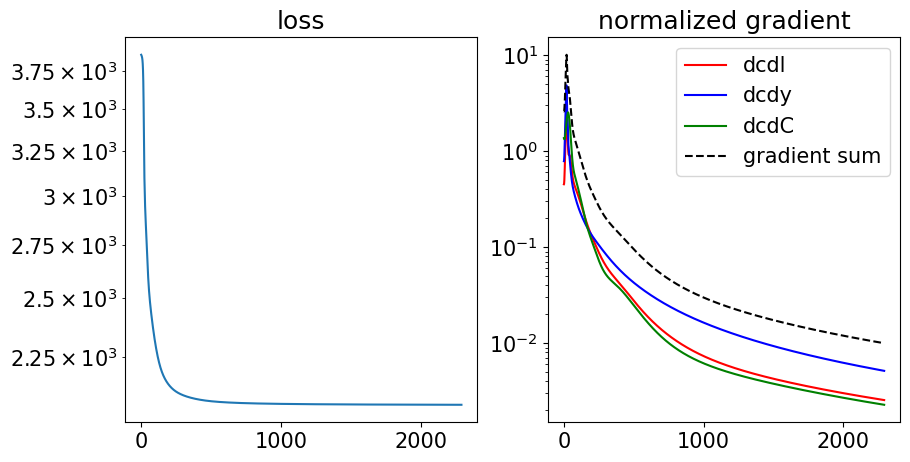

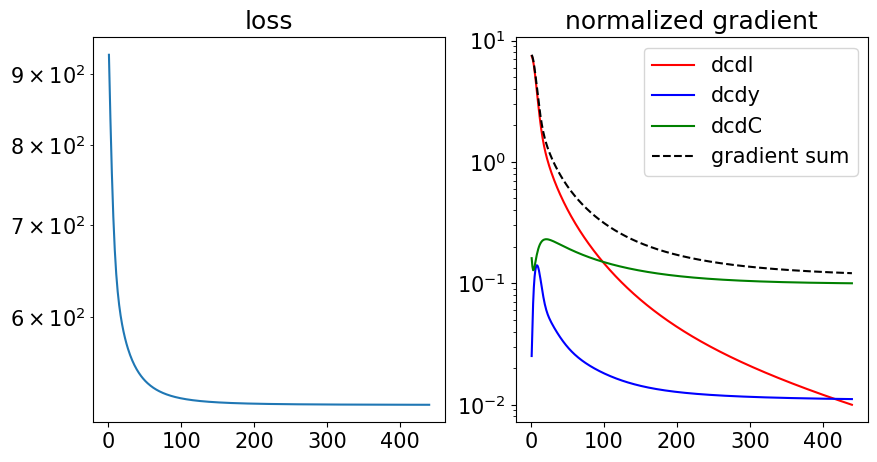

Number of clusters in latents = 3


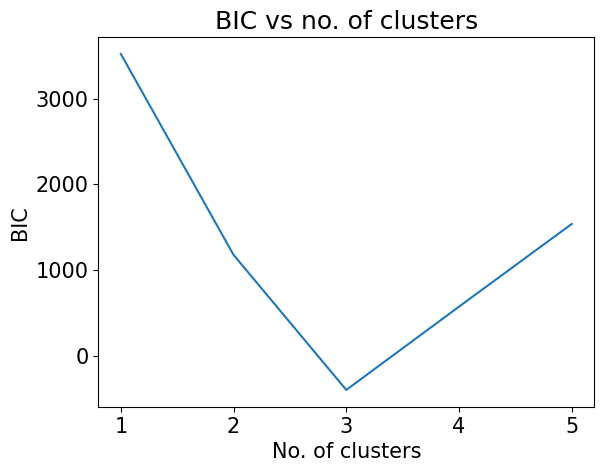

In [5]:
obj = phenotype_constraint(cow_data, metadata, metnames, eta, num_steps, num_latents, alpha)

In [6]:
obj.phenotype_constraint_list()

100%|██████████| 10/10 [27:18<00:00, 163.81s/it]


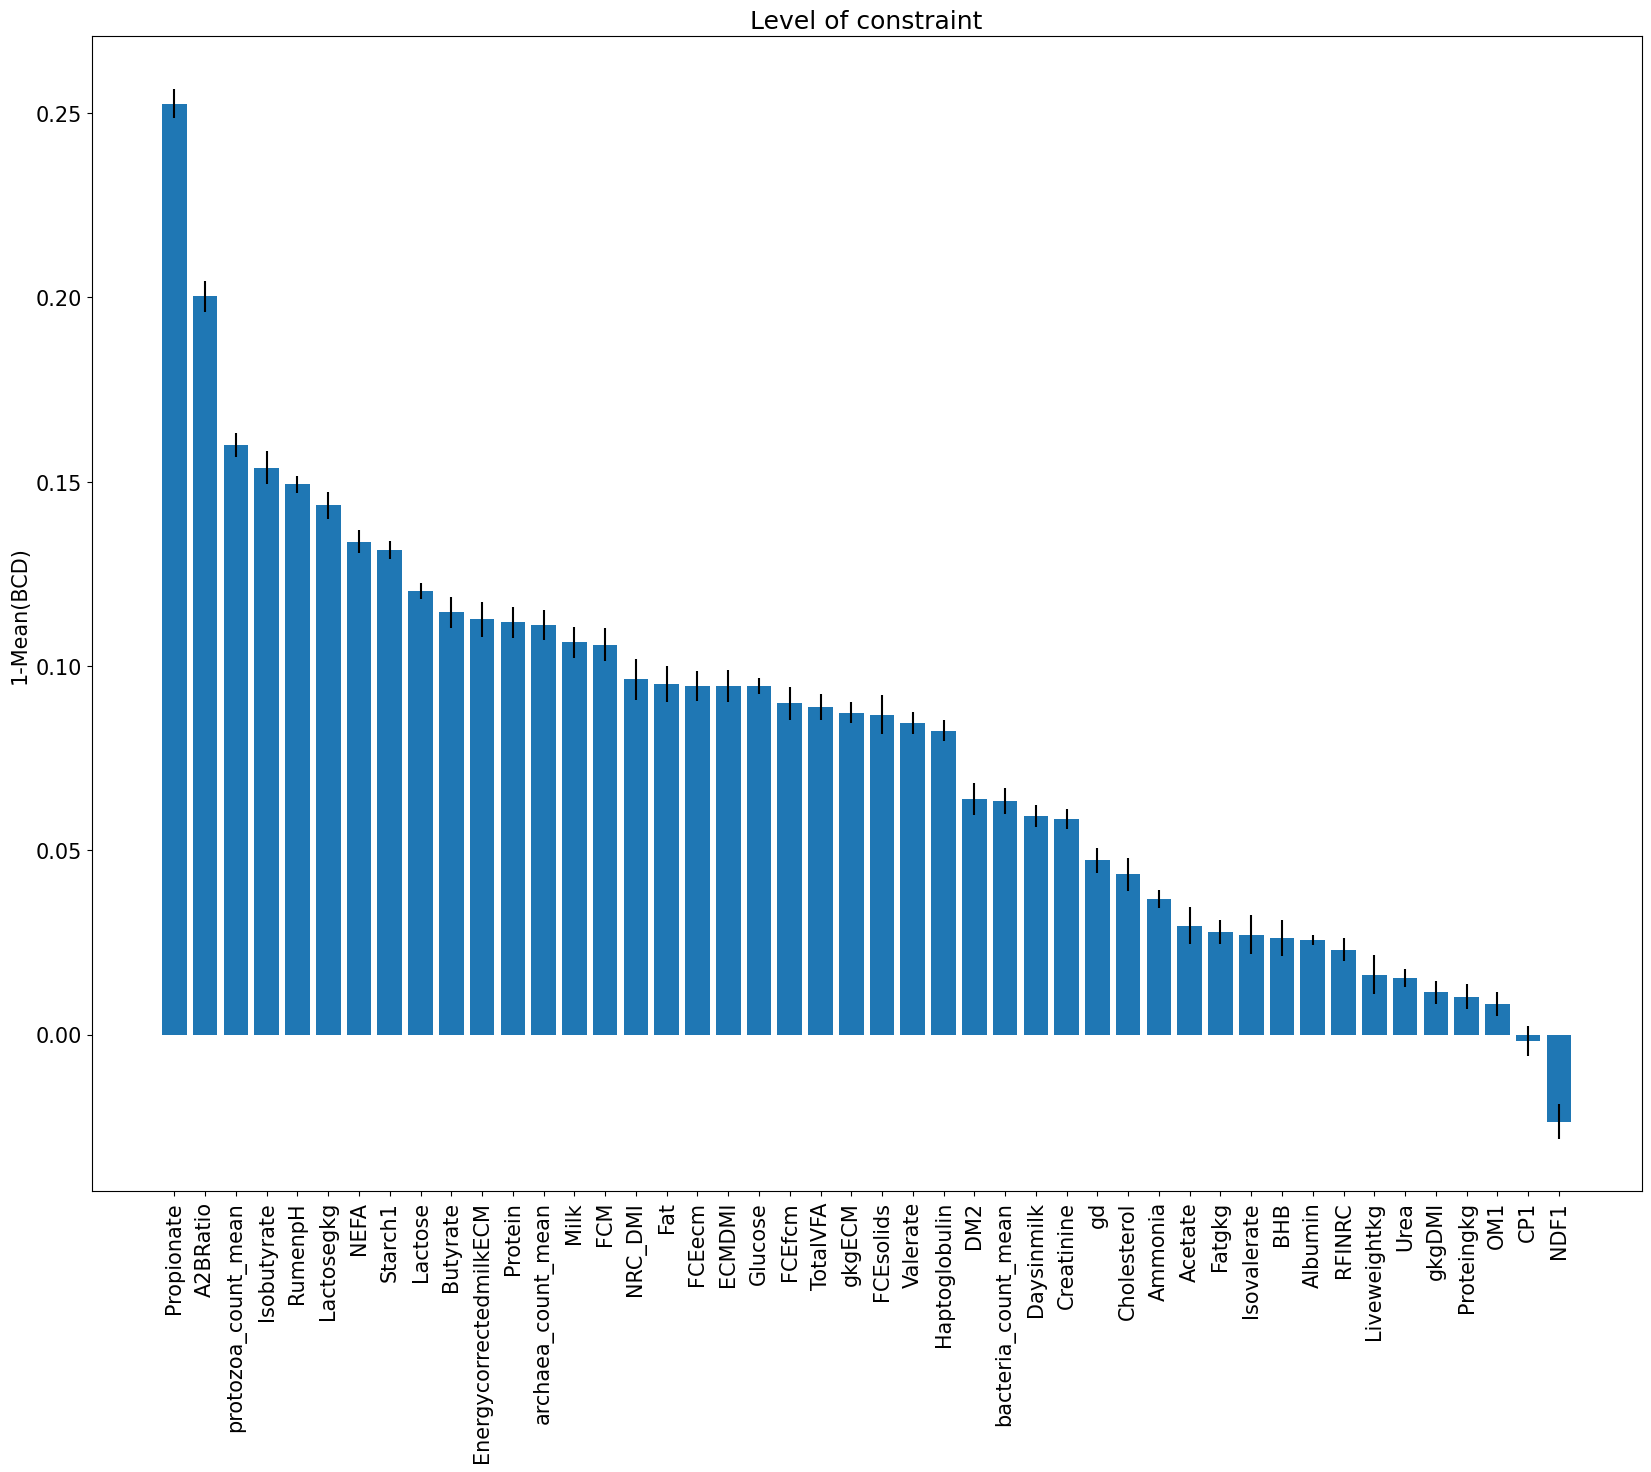

In [21]:
constraint_level_std = np.std(obj.constraint_level_list, axis=0)

idxs = np.argsort(obj.constraint_level)[::-1]
plt.figure(figsize=(20, 15))
# plt.boxplot(np.array(obj.constraint_level_list)[:, idxs])
plt.bar(obj.metadata_names[idxs], np.array(obj.constraint_level)[idxs], yerr=constraint_level_std[idxs])

plt.xticks(rotation=90)
plt.ylabel('1-Mean(BCD)')
plt.title('Level of constraint')
plt.show()

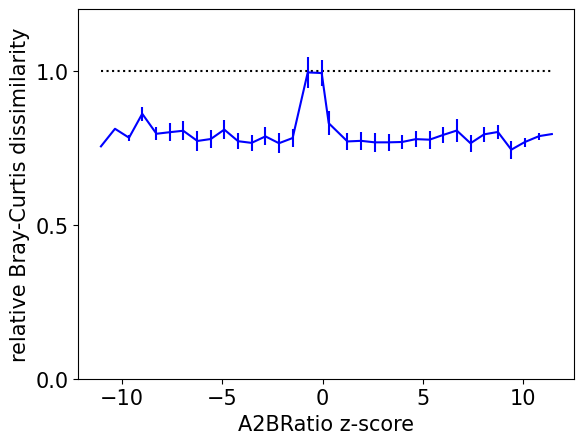

In [25]:
obj.rel_BCD_vs_phenotype('A2BRatio')

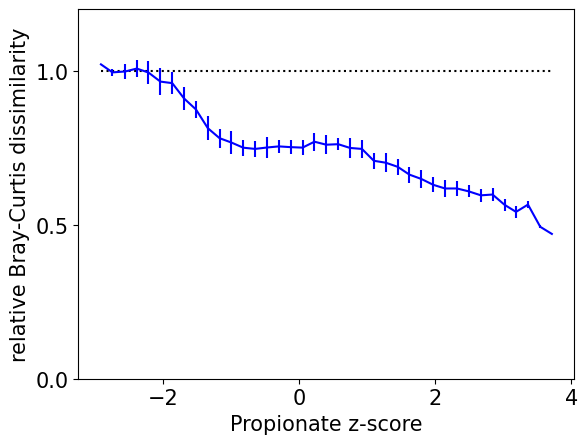

In [26]:
obj.rel_BCD_vs_phenotype('Propionate')

In [14]:
np.sort(obj.metadata_names)

array(['A2BRatio', 'Acetate', 'Albumin', 'Ammonia', 'BHB', 'Butyrate',
       'CP1', 'Cholesterol', 'Creatinine', 'DM2', 'Daysinmilk', 'ECMDMI',
       'EnergycorrectedmilkECM', 'FCEecm', 'FCEfcm', 'FCEsolids', 'FCM',
       'Fat', 'Fatgkg', 'Glucose', 'Haptoglobulin', 'Isobutyrate',
       'Isovalerate', 'Lactose', 'Lactosegkg', 'Liveweightkg', 'Milk',
       'NDF1', 'NEFA', 'NRC_DMI', 'OM1', 'Propionate', 'Protein',
       'Proteingkg', 'RFINRC', 'RumenpH', 'Starch1', 'TotalVFA', 'Urea',
       'Valerate', 'archaea_count_mean', 'bacteria_count_mean', 'gd',
       'gkgDMI', 'gkgECM', 'protozoa_count_mean'], dtype='<U22')

In [10]:
obj.create_in_silico_samples(3*1e7)

In [24]:
with open("/home/ks2823/palmer_scratch/my_object.pkl", "wb") as f:
    pickle.dump(obj, f)

In [ ]:
with open("/home/ks2823/palmer_scratch/my_object.pkl", "rb") as f:
    obj = pickle.load(f)

In [6]:
top_3_phen = ['A2BRatio', 'protozoa_count_mean', 'Propionate']
top_3_list, top_3_pred_list = np.array(obj.bcd_constrained_by_meta(top_3_phen))
print('top 3 list computed')

bot_3_phen = ['OM1', 'NDF1', 'CP1']
bot_3_list, bot_3_pred_list = np.array(obj.bcd_constrained_by_meta(bot_3_phen))

rng_3_list = []
num_succesful = 0
for i in range(10):
    try:
        rng_3_phen = obj.metadata_names[np.random.permutation(len(obj.metadata_names))[:3]]
        rng_3_bcd, rng_3_pred = obj.bcd_constrained_by_meta(bot_3_phen)
        rng_3_list.append(rng_3_bcd)
        rng_3_pred_list.append(rng_3_pred)
    except:
        continue
    num_succesful += 1
print(num_succesful)
rng_3_list = np.array(rng_3_list).reshape(-1)

top 3 list computed


In [13]:
obj.rng_pairs_bcd()

In [15]:
obj.rng_bcd_list.shape

(99844,)

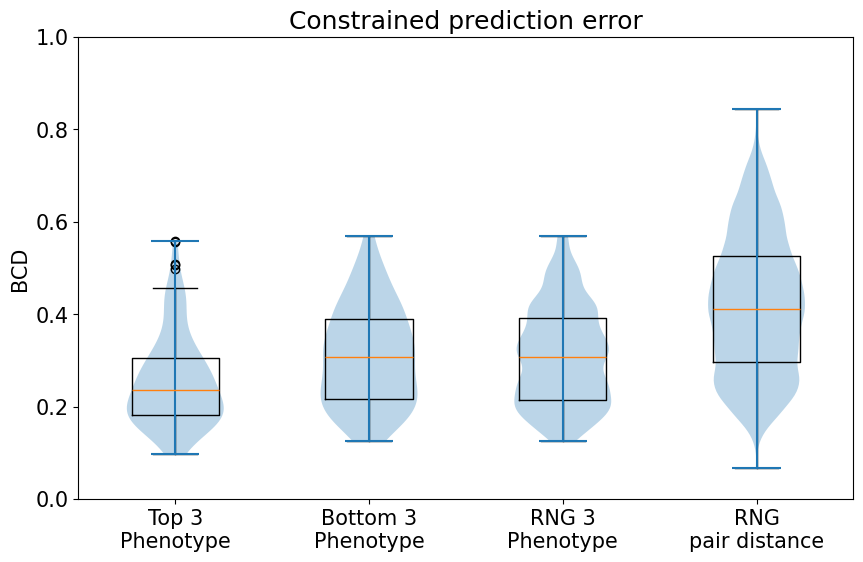

In [26]:
# Define labels
labels = ['Top 3\nPhenotype', 'Bottom 3\nPhenotype', 'RNG 3\nPhenotype', 'RNG\npair distance']

# Create a figure with a broader width
plt.figure(figsize=(10, 6))  # Adjust width and height as needed

# Create boxplot
plt.boxplot([top_3_list, bot_3_list, rng_3_list, obj.rng_bcd_list], labels=labels)

# Create violin plot
plt.violinplot([top_3_list, bot_3_list, rng_3_list, obj.rng_bcd_list])

# Customize plot
plt.ylabel('BCD')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title('Constrained prediction error')

# Save and show plot
plt.savefig('BCD_constrained.png', bbox_inches='tight')  # bbox_inches='tight' ensures the labels are not cut off
plt.show()

In [ ]:
np.isin(obj.metadata_names, ['A2BRatio'])

In [ ]:
new_cov = np.copy(obj.best_model.covariances_)
new_mean = np.copy(obj.best_model.means_)

constrain_phenotype = ['Propionate']
constrain_value = [0.5]

for phen, val in zip(constrain_phenotype, constrain_value):
    C_phen = obj.C[:, obj.metadata_names==phen].reshape(-1)
    cov = 0.5*np.sqrt(len(constrain_phenotype))*np.diag(C_phen**2)
    mean = val*C_phen/np.linalg.norm(C_phen)**2
    new_cov = np.vstack((new_cov, cov.reshape(1, obj.num_latents, obj.num_latents)))
    new_mean = np.vstack((new_mean, mean.reshape(1, obj.num_latents)))

In [ ]:
obj.metadata_names

In [ ]:
gm = obj.best_model
gm_latents, gm_labels = gm.sample(5*1e5)
gm_data = np.exp(-np.matmul(gm_latents, self.theta))
gm_data /= np.sum(gm_data, axis=1)[:, np.newaxis]
gm_meta = np.matmul(gm_latents, self.C)

constraints = ['Propionate', 'Starch', 'RumenpH']

for data_point in obj.data:


In [ ]:
z = np.array(pd.read_csv('fig_3_files/combined_latents.csv', index_col=0))
theta = np.array(pd.read_csv('fig_3_files/theta.csv', index_col=0))
C = np.array(pd.read_csv('fig_3_files/metadata_theta.csv', index_col=0))

In [ ]:
metadata_reconstructed = np.matmul(z, C)

metadata_z_scored = metadata - np.mean(metadata, axis=0)[np.newaxis, :]
metadata_z_scored = metadata_z_scored/np.std(metadata, axis=0)[np.newaxis, :]
x = np.linspace(np.min(metadata_z_scored), np.max(metadata_z_scored), 100)

plt.scatter(metadata_z_scored, metadata_reconstructed)
plt.plot(x,x, color='red')
plt.title('Metadata Reconstruction')
plt.xlabel('Z-scored metadata')
plt.ylabel('Reconstructed')
plt.xlim(np.min([metadata_z_scored, metadata_reconstructed])-1, np.max([metadata_z_scored, metadata_reconstructed])+1)
plt.ylim(np.min([metadata_z_scored, metadata_reconstructed])-1, np.max([metadata_z_scored, metadata_reconstructed])+1)
plt.show()

In [ ]:
data_reconstructed = np.exp(-np.matmul(z, theta))
data_reconstructed /= np.sum(data_reconstructed, axis=1)[:, np.newaxis]

x = np.linspace(np.min(cow_data), np.max(cow_data), 100)


plt.scatter(cow_data, data_reconstructed)
plt.plot(x, x, color='red')
plt.xlim(np.min([cow_data, data_reconstructed])-0.01, np.max([cow_data, data_reconstructed])+0.01)
plt.ylim(np.min([cow_data, data_reconstructed])-0.01, np.max([cow_data, data_reconstructed])+0.01)
plt.title('Microbiome Reconstruction')
plt.xlabel('Data')
plt.ylabel('Reconstructed')
plt.show()

In [ ]:
z_pca = PCA(n_components=20)
pca_vars = z_pca.fit_transform(z)
evr_cumsum = np.cumsum(z_pca.explained_variance_ratio_)
plt.plot(np.arange(1, evr_cumsum.shape[0]+1), evr_cumsum)
plt.ylim(0,1)
plt.title("Cumulative explained variance plot")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
bic_list = []
for i in range(1, 6):
    best_score = -np.inf
    best_model = None
    for _ in range(100):
        gm = GM(n_components=i).fit(z)
        current_score = gm.score(z)
        if current_score > best_score:
            best_score = current_score
            best_model = gm
    bic_list.append(best_model.bic(z))

plt.plot(np.arange(1,6), bic_list)
plt.xticks(np.arange(1,6))
plt.title('BIC vs no. of clusters')
plt.xlabel('No. of clusters')
plt.ylabel('BIC')
plt.show()


In [ ]:
best_score = -np.inf
best_model = None
for _ in range(200):
    gmm = GM(n_components=3).fit(z)
    current_score = gmm.score(z)
    if current_score > best_score:
        best_score = current_score
        best_model = gmm

final_prediction = best_model.predict(z)
plt.scatter(pca_vars[:, 0], pca_vars[:, 1], c=final_prediction)
plt.show()

In [ ]:
gm_latents, gm_labels = best_model.sample(cow_data.shape[0])
gm_data = np.exp(-np.matmul(gm_latents, theta))
gm_data /= np.sum(gm_data, axis=1)[:, np.newaxis]
gm_meta = np.matmul(gm_latents, C)

In [ ]:
for i in range(cow_data.shape[1]):
    for j in range(metadata.shape[1]):
        pearson_data = np.corrcoef(cow_data[:, i], metadata[:,j])[0,1]
        pearson_model = np.corrcoef(gm_data[:, i], gm_meta[:, j])[0,1]
        plt.scatter(pearson_data, pearson_model, color='black')
x = np.linspace(-1,1, 100)
plt.plot(x,x,'--', color='red')
plt.xlabel('Pearson correlation (data)')
plt.ylabel('Pearson correlation (model)')
plt.show()

In [ ]:
rel_BCD_vs_phenotype('Propionate', best_model)

In [ ]:
# gm = best_model
# gm_latents, gm_labels = gm.sample(5*1e5)
# gm_data = np.exp(-np.matmul(gm_latents, theta))
# gm_data /= np.sum(gm_data, axis=1)[:, np.newaxis]
# gm_meta = np.matmul(gm_latents, C)

constraints = np.array(['Propionate', 'Starch', 'RumenpH'])
constrained_meta = metadata_z_scored[:, np.isin(metnames, constraints)]

for data_point, meta in zip(cow_data, constrained_meta):
    continue


In [ ]:
constrained_meta.shape